#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

In [72]:
# Testing if integration works

In [73]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [ ]:
fastmri_knee_data_dir = input("Please enter the (downloaded) data path: ")

In [74]:
file_name = f'{fastmri_knee_data_dir}/multicoil_train/file1000108.h5'
hf = h5py.File(file_name)

In [75]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'CORPD_FBK', 'max': 0.0009159000657805458, 'norm': 0.2906827581143191, 'patient_id': '120a9ed15c7402b4d558d0e522ed2dcb77b53d365ce5ec1eabe0a4137b12207d'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [76]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(37, 15, 640, 368)


In [77]:
slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume

Let's see what the absolute value of k-space looks like:

In [78]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

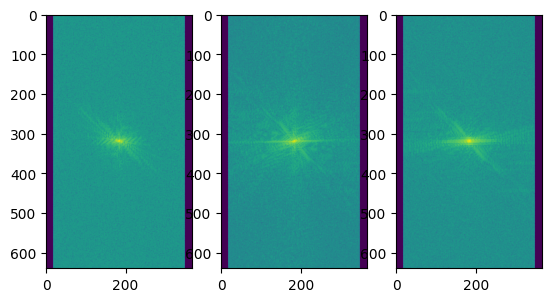

In [79]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [80]:
from atommic.collections.common.parts import apply_mask, to_tensor, fft, complex_abs, rss
from atommic.collections.common.data.subsample import Random1DMaskFunc

In [81]:
slice_kspace2 = to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fft.ifft2(slice_kspace2, centered=True, normalization="ortho")           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = complex_abs(slice_image)   # Compute absolute value to get a real image

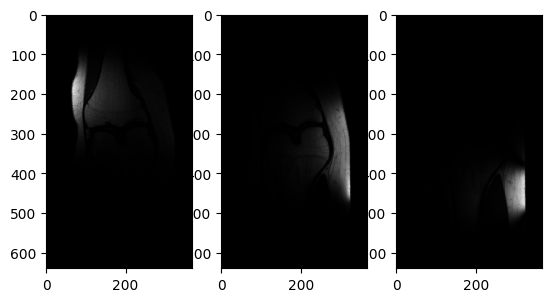

In [82]:
show_coils(slice_image_abs, [0, 5, 10], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [83]:
slice_image_rss = rss(slice_image_abs, dim=0)

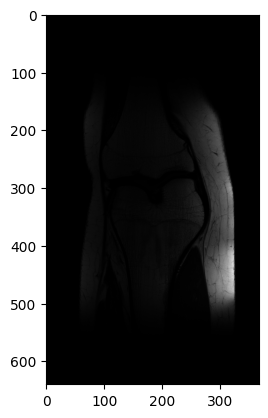

In [84]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [85]:
mask_func = Random1DMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [86]:
masked_kspace, mask, acc = apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

Let's see what the subsampled image looks like:

In [87]:
sampled_image = fft.ifft2(masked_kspace, centered=True, normalization="ortho")           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = rss(sampled_image_abs, dim=0)

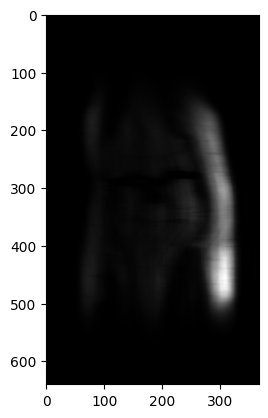

In [88]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')